In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image

from tensorflow.keras.datasets import mnist

import numpy as np
import sys, os
import matplotlib.pyplot as plt
%matplotlib inline 

In [36]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Image 35254 in training dataset:
Label: 4


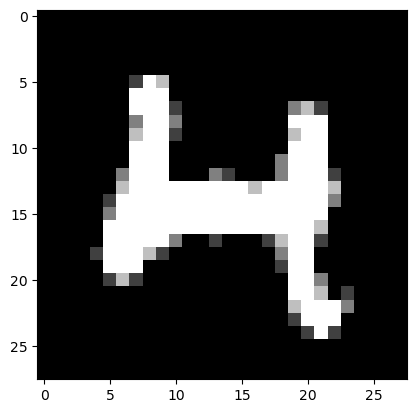

In [37]:
# Look at sample
ith = np.random.randint(X_train.shape[0])
print(f'Image {ith} in training dataset:')
print(f'Label: {y_train[ith]}')
plt.imshow(X_train[ith], cmap='gray')

In [38]:
# Flatten dataset
N, H, W = X_train.shape
D = H * W
X_train = X_train.reshape(-1, D)
X_test = X_test.reshape(-1, D)

# Scale dataset
X_train = X_train / 255.0 * 2 - 1
X_test = X_test / 255.0 * 2 - 1

In [39]:
latent_dim = 100

In [43]:
# Build Generator
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(D, activation='tanh')(x)

    model = Model(i, x)
    return model

In [44]:
# Build discriminator
def build_discriminator(img_size):
    i = Input(shape=(img_size, ))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    return model

In [45]:
# Build discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

# Build combined model
generator = build_generator(latent_dim)
z = Input(shape=(latent_dim,))
generator_output = generator(z)
discriminator.trainable = False
faked_pred = discriminator(generator_output)

combined_model = Model(z, faked_pred)
combined_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
)


In [ ]:
# Training

# Configuration
batch_size = 32
epochs = 30000
sample_period = 200 # Print result of model after each 200 epochs

directory = 'gan_images'

# Labels for training process in each batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Save of discriminator's and generator's losses
d_loss = []
g_loss = []

if not os.path.exists(directory):
    os.makedirs(directory)
    print(f'Directory created: {directory}')
else:
    print(f'Directory {directory} is already existed')

In [46]:
def sample_images(epoch, parent_dir):
    rows, cols = 5, 5
    noise = np.random.randn(rows*cols, latent_dim)
    imgs = generator.predict(noise)

    fig, ax = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            ax[i, j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            ax[i, j].axis('off')
            idx += 1
    path = os.path.join(parent_dir, f'{epoch}.png')
    fig.savefig(path)
    plt.close()

In [ ]:
for epoch in epochs:
    # Train discriminator
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_images = X_train[idx]

    